In [1]:
# Sample to be processed
study = 'scmznos_valtor_combined'


In [2]:
# Input/output/resource directories
place = 'nemo'
scratchdir = "/plus/scratch/users/scott/projects/scmznos_valtor"
rawdir = f'{scratchdir}/raw_data'
outdir = f'{scratchdir}/project_results'
datadir = f'{scratchdir}/resources'
commonsdir = '/plus/data/@data_scott/common_resources'


In [3]:
# Load libraries
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy import io

import scanpy as sc
import anndata as ad
import pybiomart as pbm
import leidenalg as la
import scrublet as scr

import graphtools as gt
from pygsp import graphs, filters
import phate
import magic
import scprep
import sklearn
import meld

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import natsort

# Package settings
sc.settings.autosave = False
sc.settings.figdir = f'{outdir}/'
np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['animation.embed_limit'] = 1000
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
# Show loaded libraries
import session_info
session_info.show()

In [5]:
# Load preprocessed data
sdata_valtor = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_scmznos_valtor_combined_cells_preprocessed_FINAL.h5ad')
sdata_valtor

AnnData object with n_obs × n_vars = 10551 × 19782
    obs: 'Sample', 'Mutant_A', 'Mutant_B', 'WT_A', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_noncoding', 'log1p_total_counts_noncoding', 'pct_counts_noncoding', 'total_counts_label', 'log1p_total_counts_label', 'pct_counts_label', 'Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Detected_GFPCAAX', 'Detected_DSRED38WT', 'Detected_HCD4ENRICHED', 'Detected_number', 'Detected_any', 'Transplant', 'Transplant_WT', 'Transplant_KO', 'Condition_marker', 'WT_marker', 'KO_marker', 'Host_marker', 'log10_total_counts', 'Condition_SNP', 'Condition', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'E

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

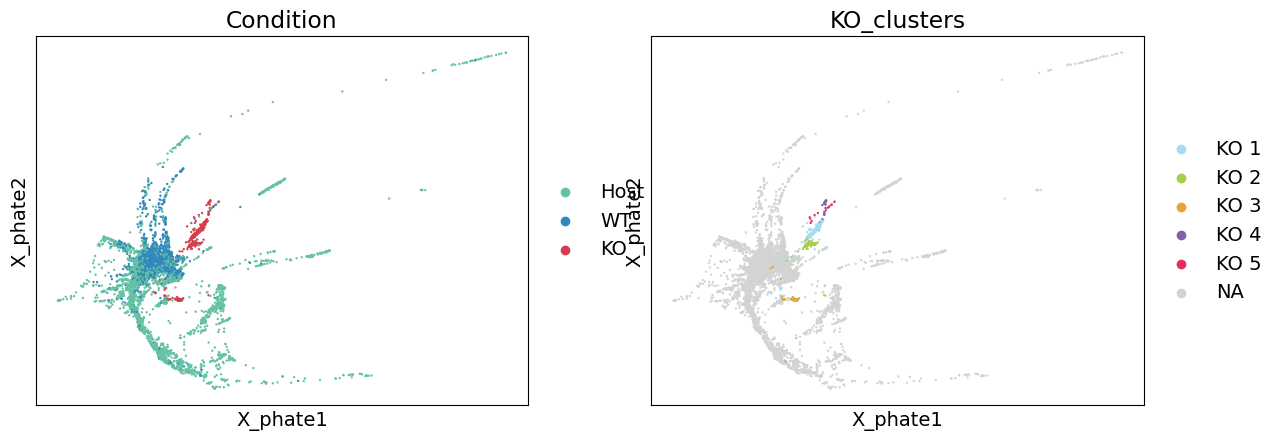

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

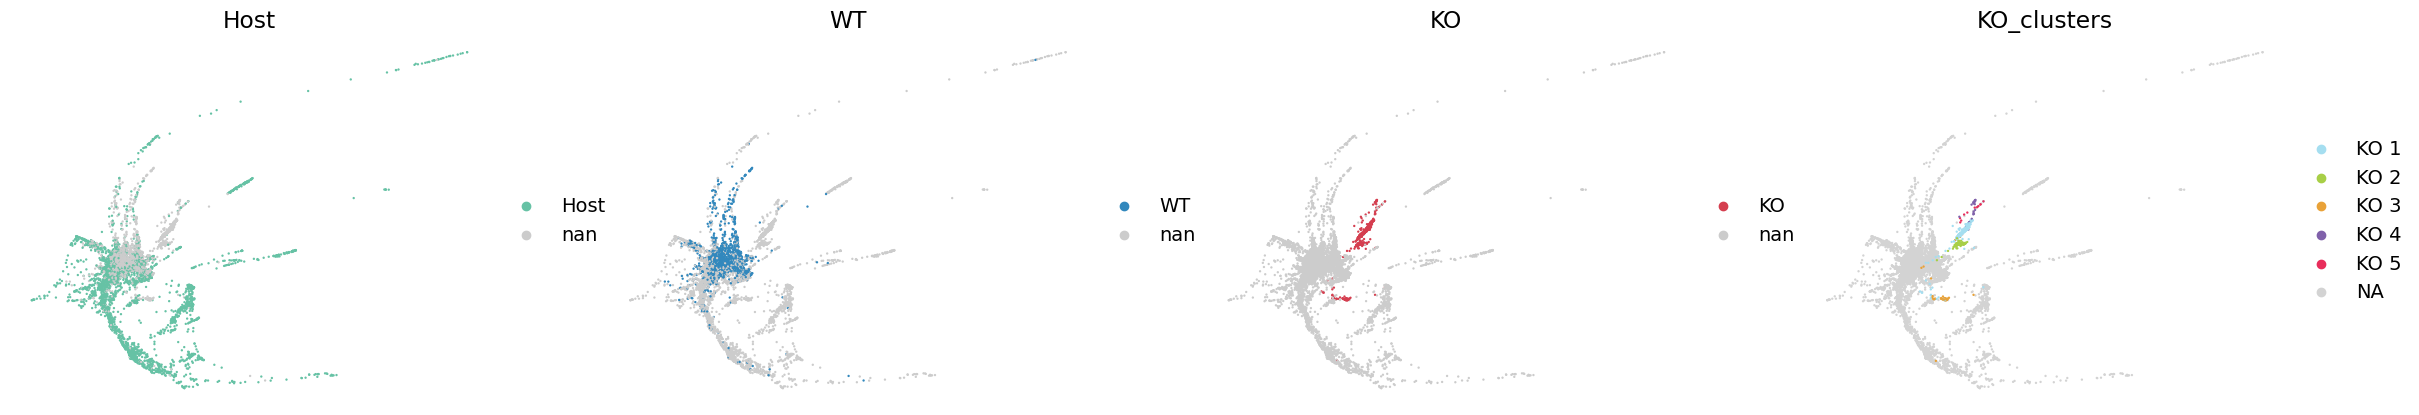

In [6]:
# Draw phate plot using HVGs
sc.pl.embedding(sdata_valtor, basis='X_phate', color=['Condition', 'KO_clusters'], sort_order=True, vmin=0, use_raw = False, color_map='magma')
sc.pl.embedding(sdata_valtor, basis='X_phate', color=['Host', 'WT', 'KO', 'KO_clusters'], frameon=False, sort_order=True, vmin=0, use_raw = False, color_map='magma')


In [7]:
# Load preprocessed data
sdata_shier = sc.read_h5ad(f'{commonsdir}/scDatasets/shier2018_sc/preprocessed_data/Anndata_scmultiome_curbos_shier_subset_cells_preprocessed.h5ad')
sdata_shier.obs.rename(columns={"Germlayer": "Shier_germlayer", "Tissue": "Shier_tissue", "Subtissue": "Shier_subtissue"}, inplace=True)
sdata_shier


AnnData object with n_obs × n_vars = 37183 × 17238
    obs: 'n.Genes', 'n.Trans', 'CELL', 'STAGE', 'GENO', 'BATCH', 'SEQ', 'HPF', 'SAMPLE', 'NUM_READS', 'NUM_TRANSCRIPTS', 'NUM_GENES', 'MT_TRANSCRIPTS', 'PERCENT_MT', 'stage.nice', 'Shier_subtissue', 'Infomap20', 'Infomap30', 'ClusterNum', 'segment', 'node', 'Louvain15', 'Louvain20', 'Louvain30', 'Shier_tissue', 'Shier_germlayer', 'doublet_scores', 'predicted_doublets', 'pct_counts_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'log10_total_counts', 'S_score', 'G2M_score', 'phase', 'Ectoderm_Shier_germlayer_score', 'Endoderm_Shier_germlayer_score', 'Mesoderm_Shier_germlayer_score', 'Other_Shier_germlayer_score', 'Axial-mesoderm_Shier_tissue_score', 'Endoderm_Shier_tissue_score', 'Fore-mid-brain_Shier_tiss

In [8]:
# Add Curtis annotations to the Shier object
annot = pd.read_csv(f'{commonsdir}/scDatasets/zsf_reference/preprocessed_data/Obs_zsf_reference_4-24hpf_cells_all_genes_annotated.csv', index_col=0)
annot.index = annot.cell_id
annot = annot[annot['study'] == "Shier"][['Germlayer', 'Tissue']].astype('category')
annot = sdata_shier.obs.merge(annot, how='left', left_index=True, right_index=True)
annot = annot.fillna(value={"Germlayer": 'Undifferentiated', "Tissue": 'ESC_early'})
sdata_shier.obs = annot
del annot
sdata_shier.obs

/tmp/ipykernel_697007/3035635383.py:2: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,224,225,226) have mixed types. Specify dtype option on import or set low_memory=False.
  annot = pd.read_csv(f'{commonsdir}/scDatasets/zsf_reference/preprocessed_data/Obs_zsf_reference_4-24hpf_cells_all_genes_annotated.csv', index_col=0)


n.Genes  n.Trans                        CELL  \
ZFHIGH_WT_DS5_AAAAGTTGCCTC     2762     6203  ZFHIGH_WT_DS5_AAAAGTTGCCTC   
ZFHIGH_WT_DS5_AAACAAGTGTAT     1557     2480  ZFHIGH_WT_DS5_AAACAAGTGTAT   
ZFHIGH_WT_DS5_AAACACCTCGTC     2345     4502  ZFHIGH_WT_DS5_AAACACCTCGTC   
ZFHIGH_WT_DS5_AAATGAGGTTTN     3080     7218  ZFHIGH_WT_DS5_AAATGAGGTTTN   
ZFHIGH_WT_DS5_AACCCTCTCGAT     5427    21670  ZFHIGH_WT_DS5_AACCCTCTCGAT   
...                             ...      ...                         ...   
ZF6S_WT_DS5b_TTTTGAGCGTCC       758     1682   ZF6S_WT_DS5b_TTTTGAGCGTCC   
ZF6S_WT_DS5b_TTTTGGCCGGTT      1459     4191   ZF6S_WT_DS5b_TTTTGGCCGGTT   
ZF6S_WT_DS5b_TTTTGTTTGGAC      1248     2944   ZF6S_WT_DS5b_TTTTGTTTGGAC   
ZF6S_WT_DS5b_TTTTTCTGGCAC      1328     3434   ZF6S_WT_DS5b_TTTTTCTGGCAC   
ZF6S_WT_DS5b_TTTTTTCGCCTN      1289     3133   ZF6S_WT_DS5b_TTTTTTCGCCTN   

                             STAGE GENO BATCH  SEQ   HPF      SAMPLE  \
ZFHIGH_WT_DS5_AAAAGTTGCCTC  ZFHIGH   WT   DS5  DS5   3.3  ZFHIGH-DS5   
ZFHIGH_WT_DS5_AAACAAGTGTAT  ZFHIGH   WT   DS5  DS5   3.3  ZFHIGH-DS5   
ZFHIGH_WT_DS5_AAACACCTCGTC  ZFHIGH   WT   DS5  DS5   3.3  ZFHIGH-DS5   
ZFHIGH_WT_DS5_AAATGAGGTTTN  ZFHIGH   WT   DS5  DS5   3.3  ZFHIGH-DS5   
ZFHIGH_WT_DS5_AACCCTCTCGAT  ZFHIGH   WT   DS5  DS5   3.3  ZFHIGH-DS5   
...                            ...  ...   ...  ...   ...         ...   
ZF6S_WT_DS5b_TTTTGAGCGTCC     ZF6S   WT  DS5b  DS5  12.0   ZF6S-DS5b   
ZF6S_WT_DS5b_TTTTGGCCGGTT     ZF6S   WT  DS5b  DS5  12.0   ZF6S-DS5b   
ZF6S_WT_DS5b_TTTTGTTTGGAC     ZF6S   WT  DS5b  DS5  12.0   ZF6S-DS5b   
ZF6S_WT_DS5b_TTTTTCTGGCAC     ZF6S   WT  DS5b  DS5  12.0   ZF6S-DS5b   
ZF6S_WT_DS5b_TTTTTTCGCCTN     ZF6S   WT  DS5b  DS5  12.0   ZF6S-DS5b   

                            NUM_READS  ...  \
ZFHIGH_WT_DS5_AAAAGTTGCCTC      18445  ...   
ZFHIGH_WT_DS5_AAACAAGTGTAT       7518  ...   
ZFHIGH_WT_DS5_AAACACCTCGTC      16442  ...   
ZFHIGH_WT_DS5_AAATGAGGTTTN      29240  ...   
ZFHIGH_WT_DS5_AACCCTCTCGAT      81157  ...   
...                               ...  ...   
ZF6S_WT_DS5b_TTTTGAGCGTCC        4685  ...   
ZF6S_WT_DS5b_TTTTGGCCGGTT       12770  ...   
ZF6S_WT_DS5b_TTTTGTTTGGAC        8886  ...   
ZF6S_WT_DS5b_TTTTTCTGGCAC       10413  ...   
ZF6S_WT_DS5b_TTTTTTCGCCTN        9747  ...   

                            Skeletal-muscle_Miller_subtissue_score  \
ZFHIGH_WT_DS5_AAAAGTTGCCTC                                7.973129   
ZFHIGH_WT_DS5_AAACAAGTGTAT                                7.818200   
ZFHIGH_WT_DS5_AAACACCTCGTC                                8.099698   
ZFHIGH_WT_DS5_AAATGAGGTTTN                                7.734959   
ZFHIGH_WT_DS5_AACCCTCTCGAT                               10.865221   
...                                                            ...   
ZF6S_WT_DS5b_TTTTGAGCGTCC                                 0.000000   
ZF6S_WT_DS5b_TTTTGGCCGGTT                                 0.000000   
ZF6S_WT_DS5b_TTTTGTTTGGAC                                 0.000000   
ZF6S_WT_DS5b_TTTTTCTGGCAC                                 3.098266   
ZF6S_WT_DS5b_TTTTTTCGCCTN                                 0.000000   

                            Tailbud_Miller_subtissue_score  \
ZFHIGH_WT_DS5_AAAAGTTGCCTC                        6.299406   
ZFHIGH_WT_DS5_AAACAAGTGTAT                        2.506656   
ZFHIGH_WT_DS5_AAACACCTCGTC                        6.600747   
ZFHIGH_WT_DS5_AAATGAGGTTTN                        9.520190   
ZFHIGH_WT_DS5_AACCCTCTCGAT                        8.981539   
...                                                    ...   
ZF6S_WT_DS5b_TTTTGAGCGTCC                         0.000000   
ZF6S_WT_DS5b_TTTTGGCCGGTT                         0.000000   
ZF6S_WT_DS5b_TTTTGTTTGGAC                         0.000000   
ZF6S_WT_DS5b_TTTTTCTGGCAC                         1.322443   
ZF6S_WT_DS5b_TTTTTTCGCCTN                         3.463476   

                            VesselProg_Miller_subtissue_score  \
ZFHIGH_WT_DS5_AAAAGTTGCCTC                    

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

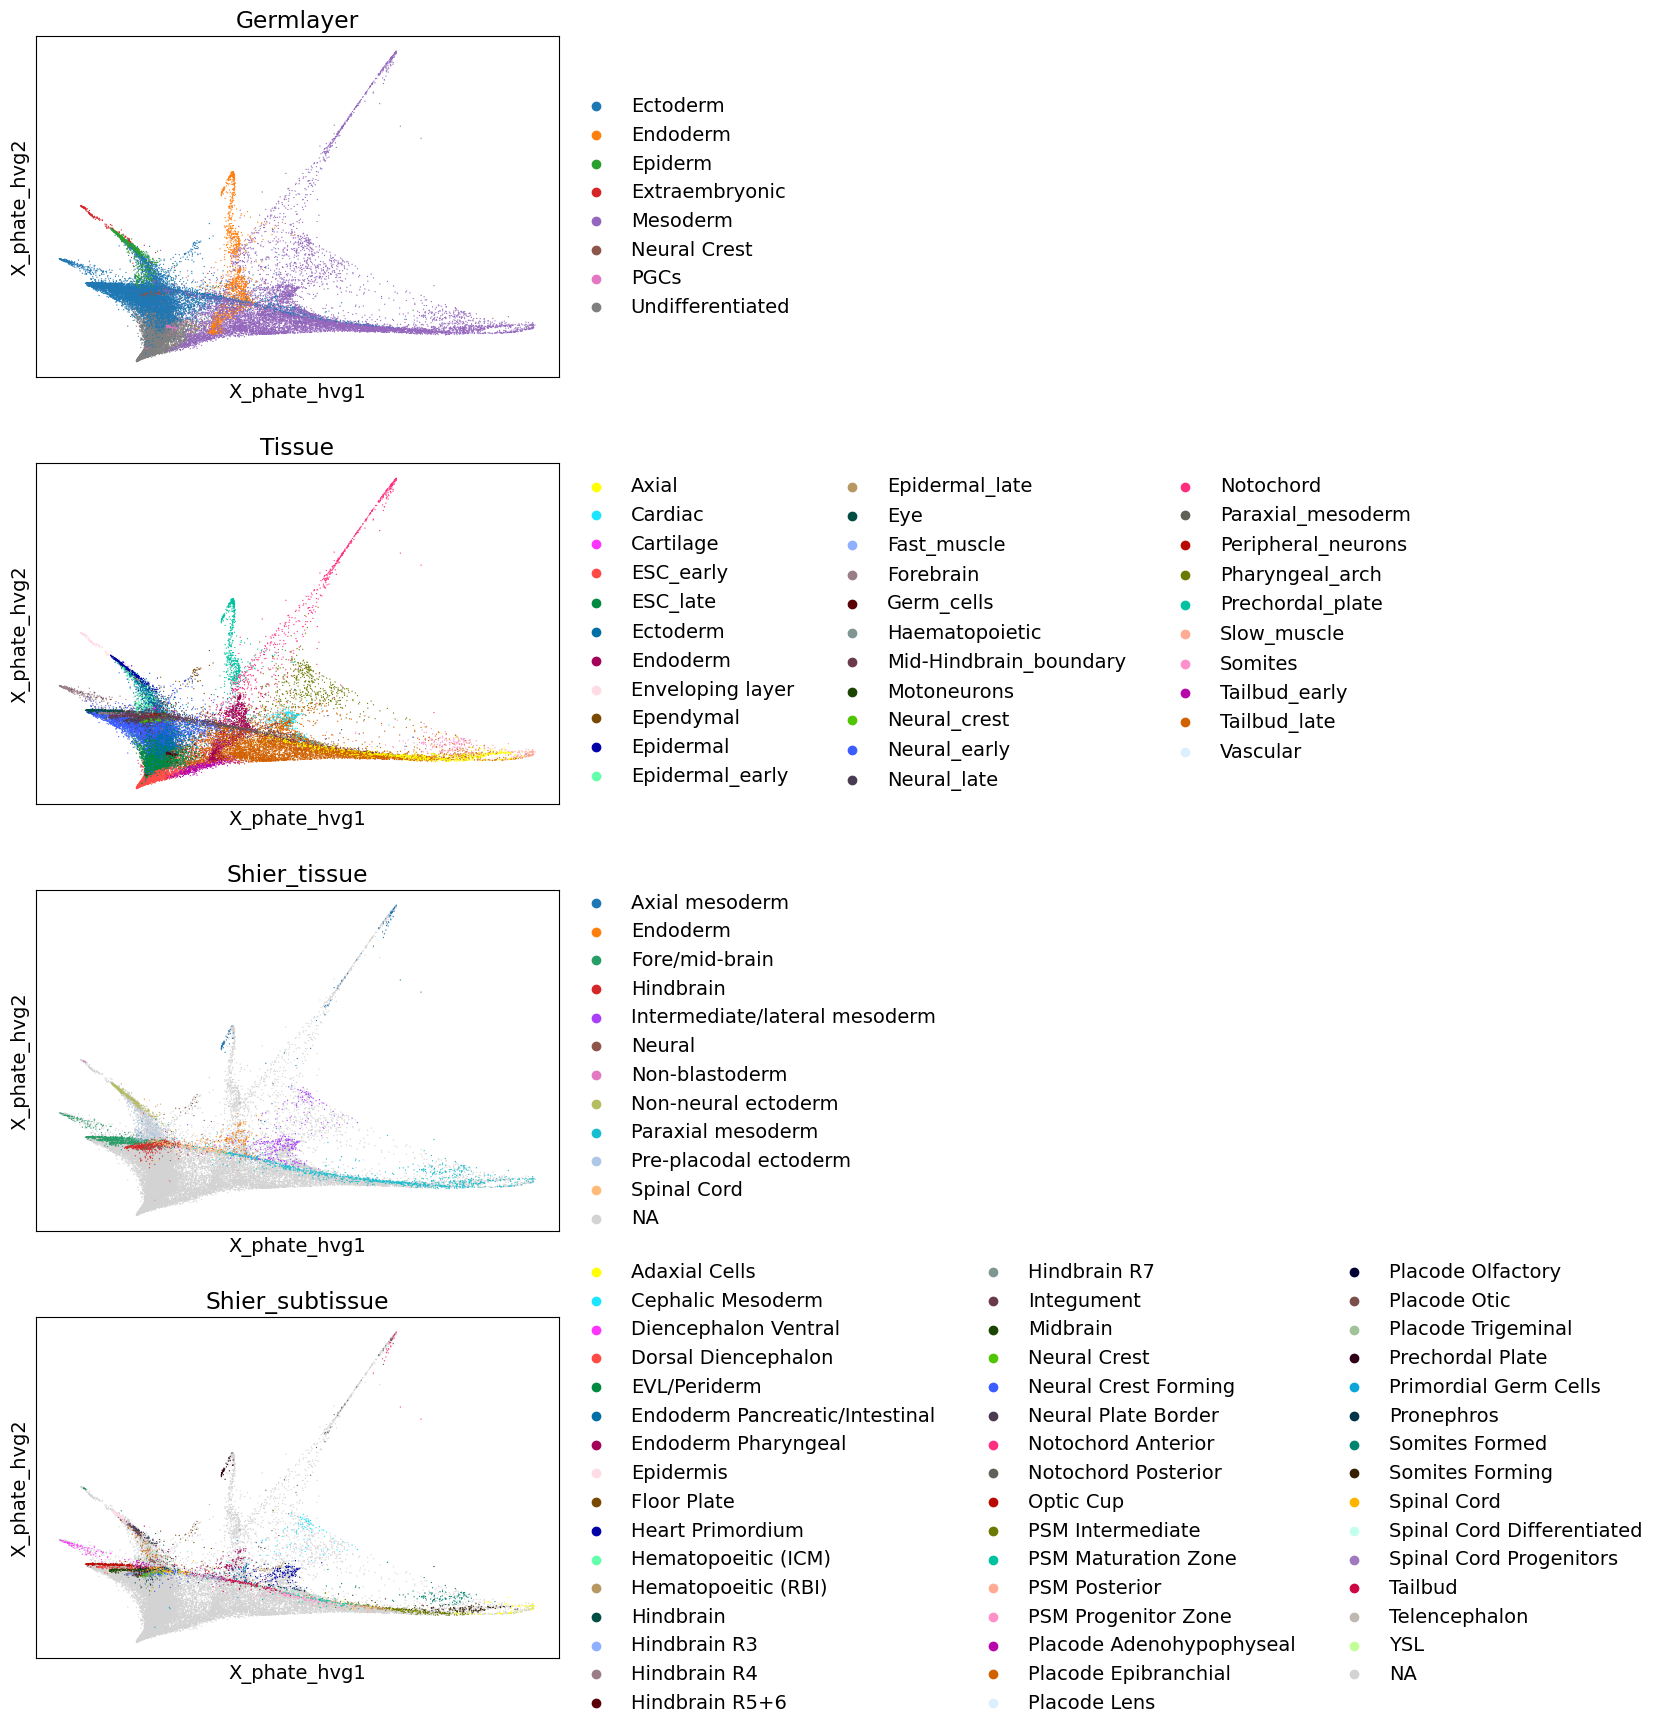

In [9]:
# Draw phate plot using HVGs
sc.pl.embedding(sdata_shier, basis='X_phate_hvg', color=['Germlayer', 'Tissue', 'Shier_tissue', 'Shier_subtissue'], sort_order=True, vmin=0, use_raw = False, color_map='magma', ncols=1)


### Concatenate and calculate QC stats

In [10]:
# Make ENSEMBL IDs index for merging
sdata_valtor.var_names = sdata_valtor.var['EnsemblID'].astype('str')

# Add var and obs info we want to keep to both objects
sdata_valtor.obs['BATCH'] = "scMZNOS"
sdata_valtor.obs['STAGE'] = "scMZNOS"
sdata_valtor.obs['HPF'] = 12
sdata_valtor.obs['Germlayer'] = 'scMZNOS'
sdata_valtor.obs['Tissue'] = 'scMZNOS'
sdata_valtor.obs['Shier_germlayer'] = 'scMZNOS'
sdata_valtor.obs['Shier_tissue'] = 'scMZNOS'
sdata_valtor.obs['Shier_subtissue'] = 'scMZNOS'
sdata_valtor.obs['Celltype'] = 'scMZNOS'


In [11]:
# Make ENSEMBL IDs index for merging
sdata_shier = sdata_shier[:, ~sdata_shier.var['Ensembl'].isna()]
sdata_shier.var_names = sdata_shier.var['Ensembl'].astype('str')
sdata_shier = sdata_shier[:, ~sdata_shier.var.index.duplicated()]

# Add var and obs info we want to keep to both objects
sdata_shier.obs['Condition'] = np.nan
sdata_shier.obs['Sample'] = sdata_shier.obs['BATCH']
sdata_shier.obs['KO_clusters'] = np.nan

sdata_shier.obs['Host'] = np.nan
sdata_shier.obs['WT'] = np.nan
sdata_shier.obs['KO'] = np.nan
sdata_shier.obs['KO_A'] = np.nan
sdata_shier.obs['KO_B'] = np.nan
sdata_shier.obs['Mutant_A'] = np.nan
sdata_shier.obs['Mutant_B'] = np.nan
sdata_shier.obs['WT_A'] = np.nan
sdata_shier.obs['Raw_GFPCAAX'] = sdata_valtor.obs['Raw_GFPCAAX'].min()
sdata_shier.obs['Raw_DSRED38WT'] = sdata_valtor.obs['Raw_DSRED38WT'].min()
sdata_shier.obs['Raw_HCD4ENRICHED'] = sdata_valtor.obs['Raw_HCD4ENRICHED'].min()
sdata_shier.obs['Detected_GFPCAAX'] = np.nan
sdata_shier.obs['Detected_DSRED38WT'] = np.nan
sdata_shier.obs['Detected_HCD4ENRICHED'] = np.nan
sdata_shier.obs['Detected_any'] = np.nan
sdata_shier.obs['Expression_GFPCAAX'] = sdata_valtor.obs['Expression_GFPCAAX'].min()
sdata_shier.obs['Expression_DSRED38WT'] = sdata_valtor.obs['Expression_DSRED38WT'].min()
sdata_shier.obs['Expression_HCD4ENRICHED'] = sdata_valtor.obs['Expression_HCD4ENRICHED'].min()


/tmp/ipykernel_697007/1022087798.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata_shier.obs['Condition'] = np.nan


In [12]:
# Combine both studies (note only matches genes that share emsembl ID)
sdata = ad.concat([sdata_valtor, sdata_shier], index_unique="_", merge="same", join='inner')
sdata.obs['study'] = sdata.obs.index.astype(str).str[-1]
sdata.obs['study'] = sdata.obs['study'].replace({'0': 'scMZNOS', '1': 'Shier'})

# # Assigns individual samples within both studies (note order matters)
# sdata.obs['batch'] = np.where(sdata.obs.index.str.contains("DS5b"), "DS5b", 
#                               np.where(sdata.obs.index.str.contains("DS5"), "DS5", "scMZNOS"))

del sdata_shier
# del sdata3
sdata
sdata.obs.BATCH.value_counts()

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/anndata/_core/merge.py:1015: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_indices = concat_indices.str.cat(label_col.map(str), sep=index_unique)
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/anndata/_core/merge.py:1026: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/anndata/_core/merge.py:1026: FutureWarning: The beh

BATCH
DS3        13023
scMZNOS    10551
DS4         7371
DS5         6909
DS2         6107
DS5b        3271
DS2b         502
Name: count, dtype: int64

In [13]:
# Restore var info from multiome
sdata.var = sdata_valtor.var.loc[sdata.var.index]
sdata.var_names = sdata.var.gene_symbol
sdata

AnnData object with n_obs × n_vars = 47734 × 15121
    obs: 'Sample', 'Mutant_A', 'Mutant_B', 'WT_A', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Detected_GFPCAAX', 'Detected_DSRED38WT', 'Detected_HCD4ENRICHED', 'Detected_any', 'log10_total_counts', 'Condition', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'Expression_HCD4ENRICHED', 'S_score', 'G2M_score', 'phase', 'Host', 'WT', 'KO', 'KO_A', 'KO_B', 'KO_clusters', 'BATCH', 'STAGE', 'HPF', 'Germlayer', 'Tissue', 'Shier_germlayer', 'Shier_tissue', 'Shier_subtissue', 'study'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbol', 'EnsemblID', 'Chromosome', 'Start', 'End', 'Strand', 'GeneSymbo

### Normalise transform score cell cycle

In [14]:
# Batch scale before cell cycle scoring and PCA
sdata.raw = sdata
sc.pp.scale(sdata, copy = False)
sdata.layers["X_scaled"] = scipy.sparse.csr_matrix(sdata.X)
sdata.X = sdata.raw.X


### Dimensionality reduction, graph and embed


In [15]:
# Define the list of variables of interest (VOIs)
VOIs = [
    'total_counts',
    'pct_counts_in_top_50_genes',
    'n_genes_by_counts',
    'phase',
    'study',
    'BATCH',
    'STAGE',
    'HPF',
    'Germlayer',
    'Tissue',
    'Shier_tissue',
    'Shier_subtissue',
    'Sample',
    'Condition',
    'Host',
    'WT',
    'KO',
    'Mutant_A',
    'Mutant_B',
    'WT_A',
    'Detected_any',
    'Detected_GFPCAAX',
    'Detected_DSRED38WT',
    'Detected_HCD4ENRICHED',
    'Expression_GFPCAAX',
    'Expression_DSRED38WT',
    'Expression_HCD4ENRICHED',
    'KO_clusters'
]

# Validate VOIs against the `obs` columns in the `sdata` AnnData object
missing_vois = [voi for voi in VOIs if voi not in sdata.obs.columns]

# Display missing variables, if any
if missing_vois:
    print(f"The following VOIs are missing in `sdata.obs`: {missing_vois}")
else:
    print("All VOIs are present in `sdata.obs`.")


All VOIs are present in `sdata.obs`.


In [16]:
# Select highly variable genes from any batch
HVG_all = []
for batch in sdata.obs['Sample'].unique():
    normalised, HVG_vars = scprep.select.highly_variable_genes(sdata[sdata.obs['Sample'] == batch].X.toarray(), sdata[sdata.obs['Sample'] == batch].var.index, cutoff=None, percentile=80)
    HVG_all.extend(HVG_vars)
    sdata.var[f'highly_variable_{batch}'] = sdata.var.index.isin(HVG_vars)
    del normalised
    print(f"Unique HVGs after {batch} {len(np.unique(np.array(HVG_all)))}")
    
sdata.var['highly_variable'] = sdata.var.index.isin(HVG_all)


Unique HVGs after Mutant_A 3024
Unique HVGs after Mutant_B 3969
Unique HVGs after WT_A 4811
Unique HVGs after DS5 5941
Unique HVGs after DS5b 6448
Unique HVGs after DS2 7076
Unique HVGs after DS3 7426
Unique HVGs after DS4 7633
Unique HVGs after DS2b 8182


In [17]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Perform PCA with 100 components
# PCA reduces dimensionality by finding orthogonal axes that explain the most variance
pca = PCA(n_components=100, random_state=42)  # Random state ensures reproducibility

# Extract the scaled data for highly variable genes
# Convert sparse matrix to dense array for PCA
X_scaled = sdata[:, sdata.var['highly_variable']].layers["X_scaled"].toarray()

# Fit the PCA model and transform the data
X_transformed = pca.fit_transform(X_scaled)

# Extract eigenvalues (explained variance per principal component)
eigenvalues = pca.explained_variance_

# Create a DataFrame to store PCA loadings
# PCA components indicate the contribution of each original feature to the PCs
pc_loadings = pd.DataFrame(
    pca.components_,  # PCA components matrix
    columns=sdata[:, sdata.var['highly_variable']].var.index,  # Column names are gene names
    index=["PC" + str(i) for i in range(1, 101)]  # Row names are PC1, PC2, ..., PC100
)

# Calculate the shape of the PCA input matrix
# M: Number of genes (features)
# N: Number of cells (samples)
M = np.shape(X_scaled)[1]  # Number of genes (features)
N = np.shape(X_scaled)[0]  # Number of cells (samples)

# Compute the Marchenko-Pastur maximum eigenvalue threshold
# MPmax determines the upper limit of eigenvalues expected from random noise
MPmax = (1 + np.sqrt(M / N))**2

# Determine the number of significant PCs
# Count the number of eigenvalues that exceed the Marchenko-Pastur threshold
npcs = sum(eigenvalues > MPmax)

# Output the number of significant PCs
npcs


93

<Axes: xlabel='Principal Component', ylabel='Explained Variance (%)'>

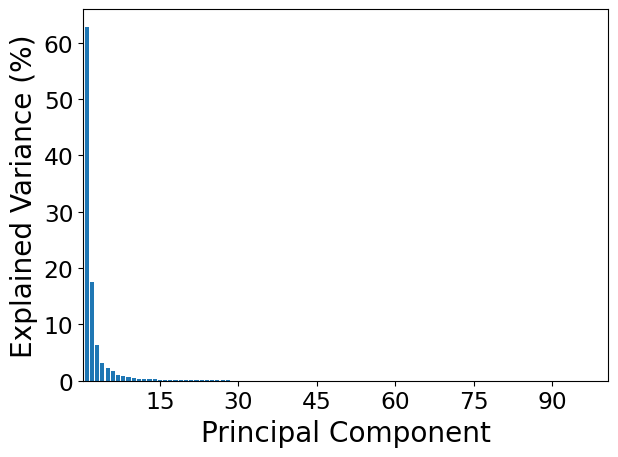

In [18]:
# Scree plot of eigenvalues
scprep.plot.scree_plot(eigenvalues, cumulative=False)


In [19]:
# Add to sdata subsetting to significant PCs
sdata.obsm["X_pca"] = X_transformed[0:,range(npcs)]


In [20]:
# # Compute PCs for initial cell graph without using HVGs
# pcs, SVs = scprep.reduce.pca(sdata.X.toarray(), n_components=100, return_singular_values=True, seed=42)
# sdata.obsm["X_pca"] = pcs[0:,0:]
# scprep.plot.scree_plot(SVs, cumulative=False)


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

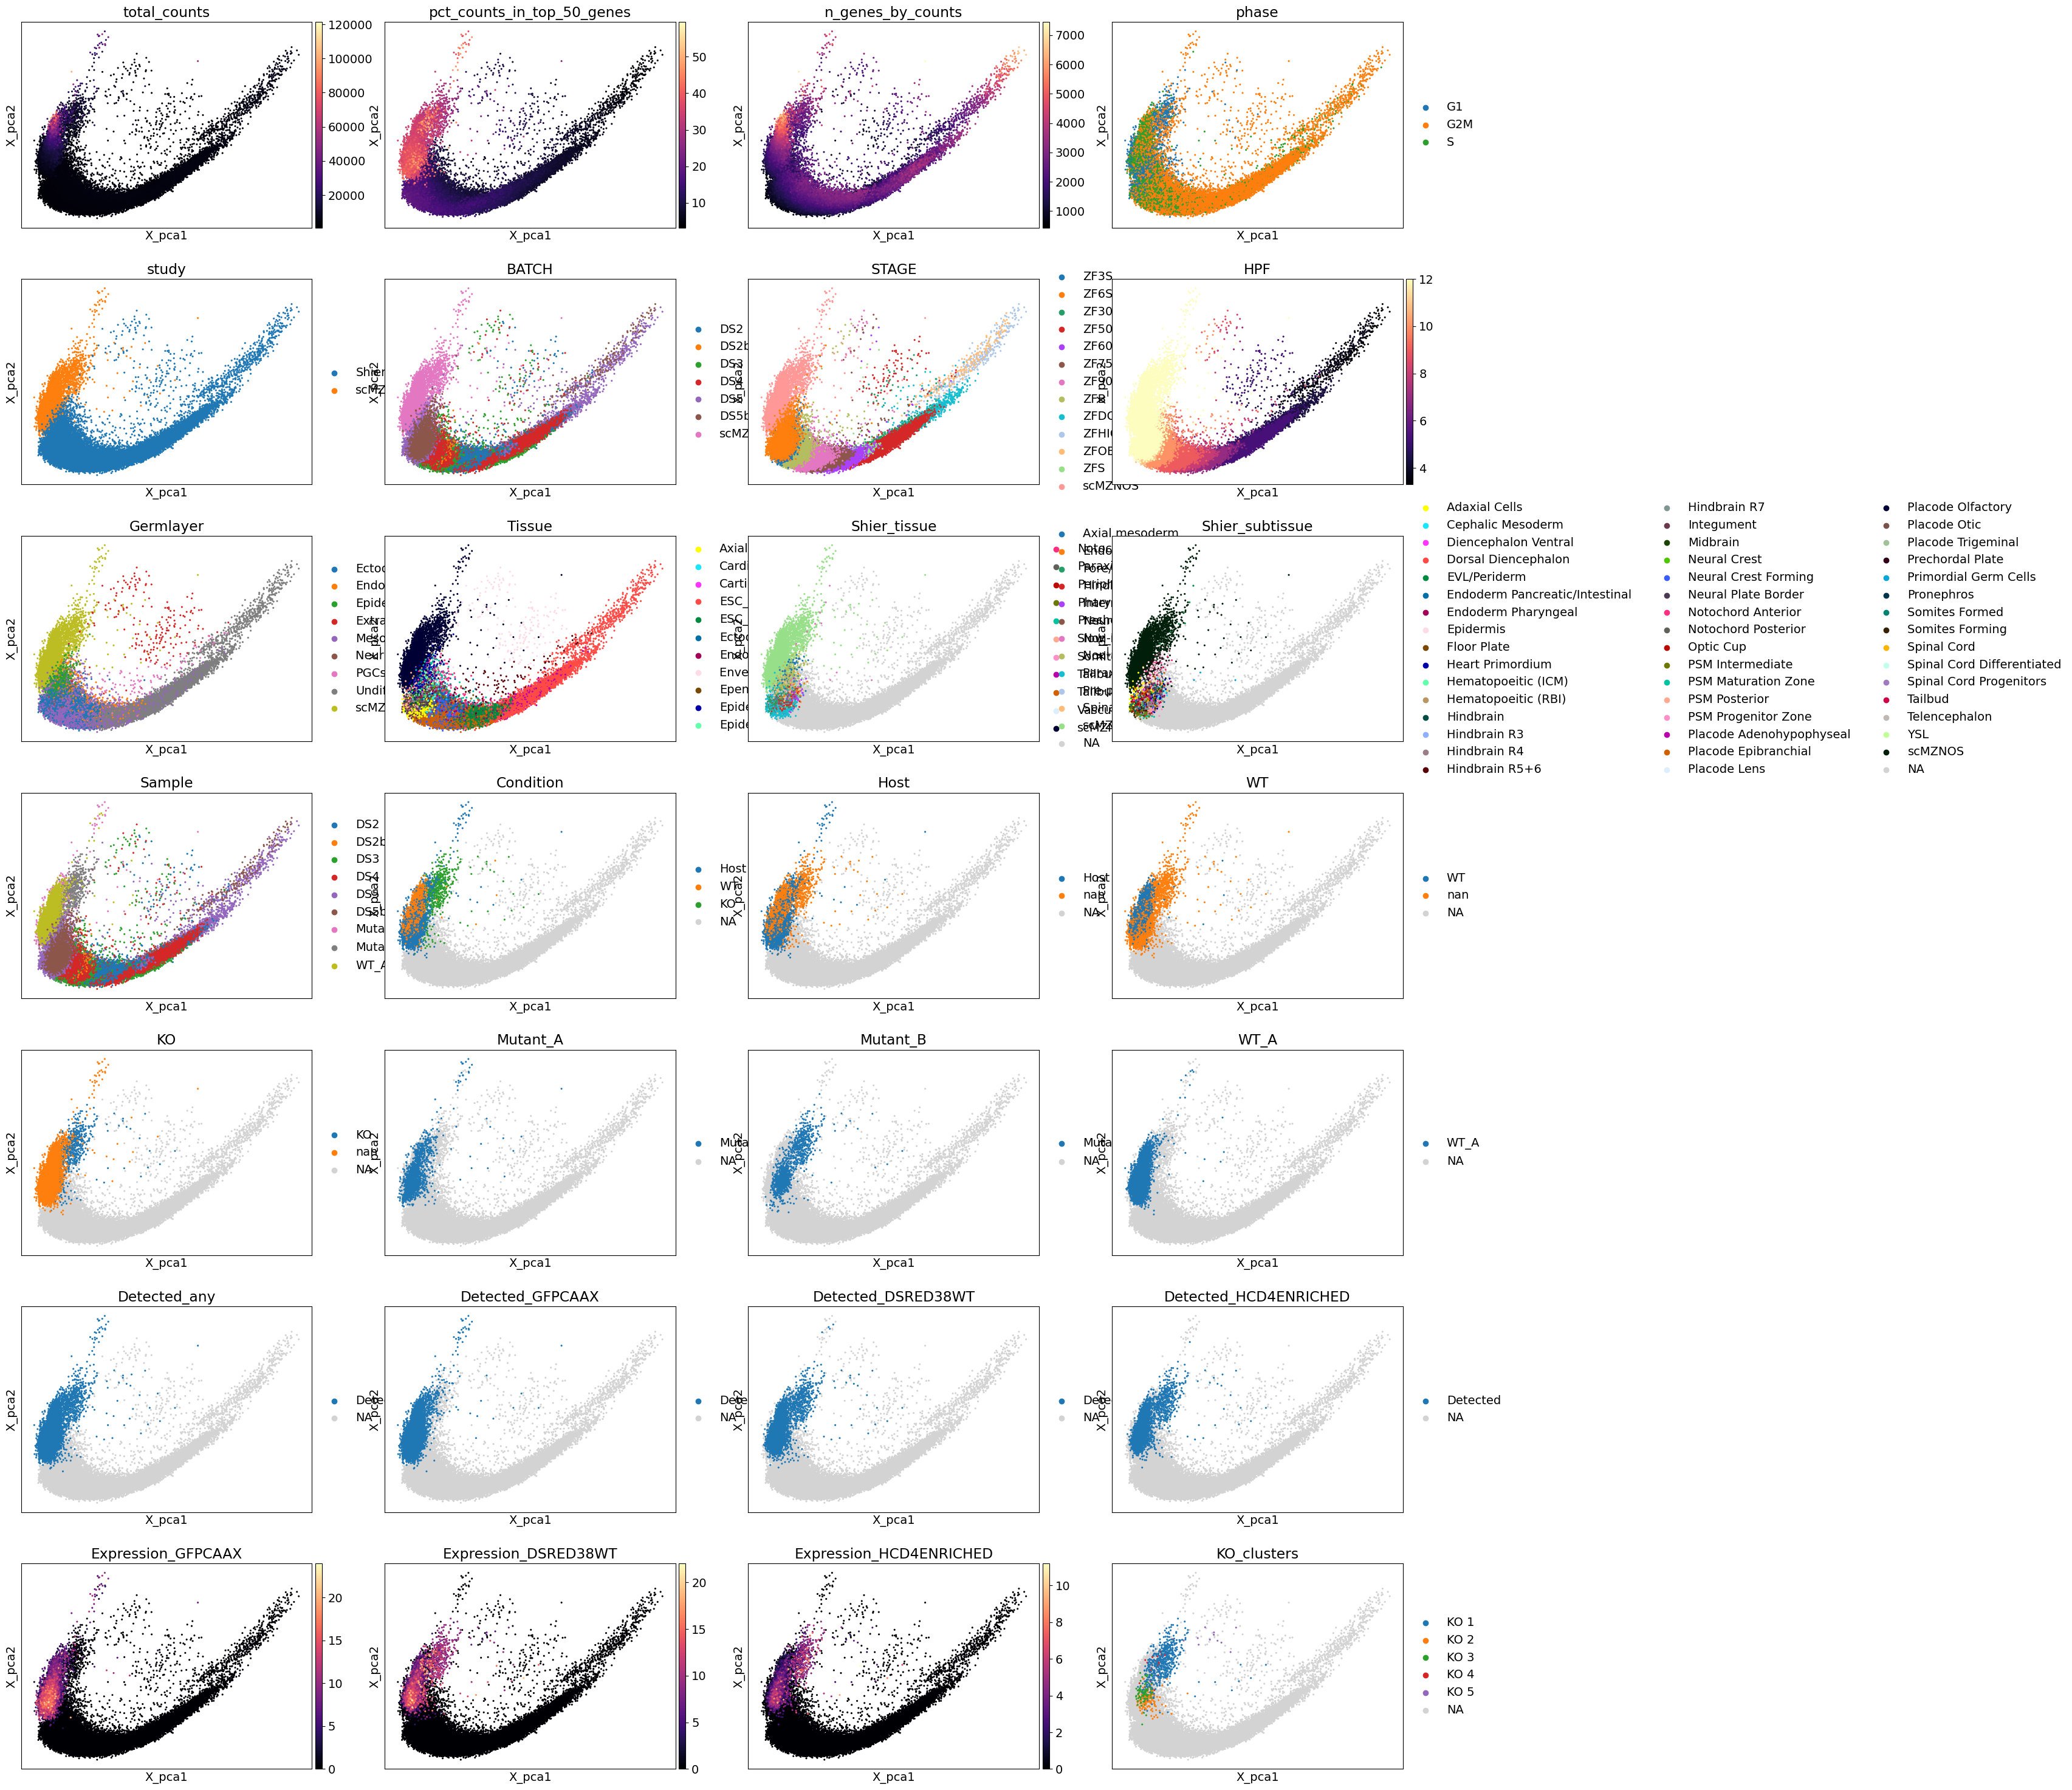

In [21]:
# Plot PC1 PC2  using HVGs with VOIs
sc.pl.embedding(sdata, basis='X_pca', color=VOIs, color_map='magma', size=20, 
                #save=f'.QC_{study}_PC1PC2_PCs_all_genes.png'
               )


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

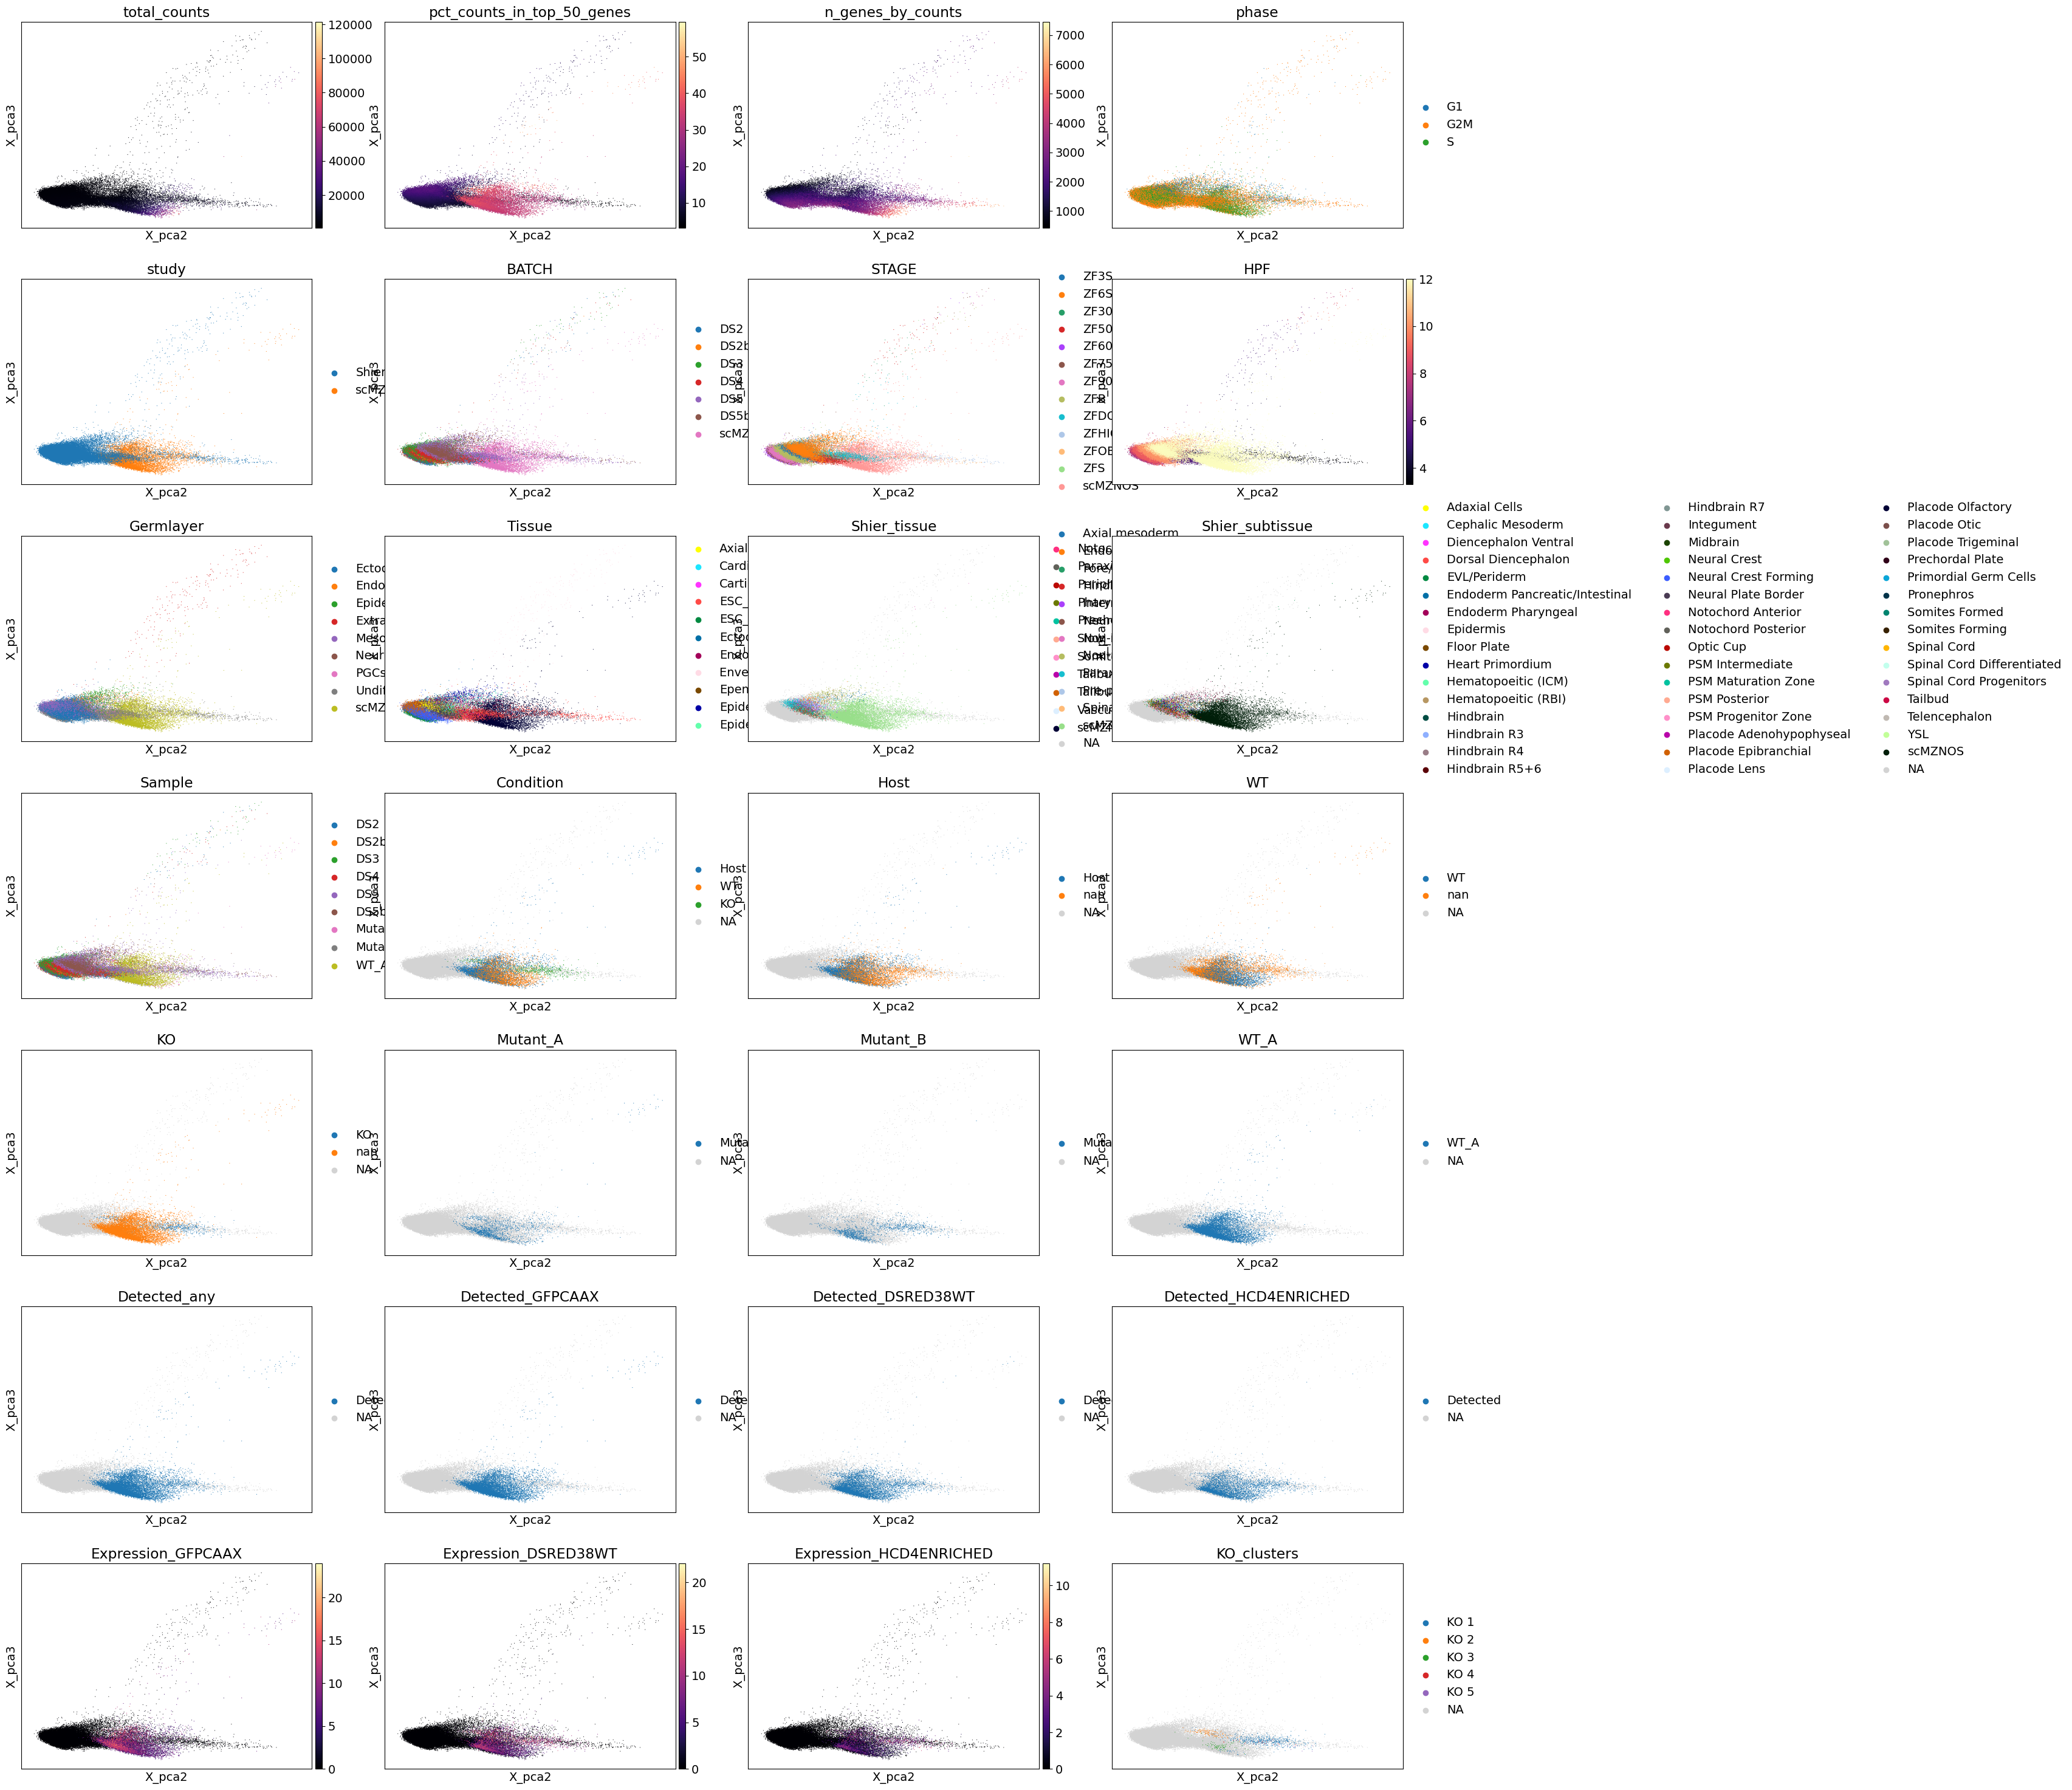

In [22]:
# Plot PC2 PC3  using HVGs with VOIs
sc.pl.embedding(sdata, basis='X_pca', color=VOIs, dimensions=(1,2), color_map='magma', 
                #save=f'.QC_{study}_PC2PC3_PCs_all_genes.png'
               )


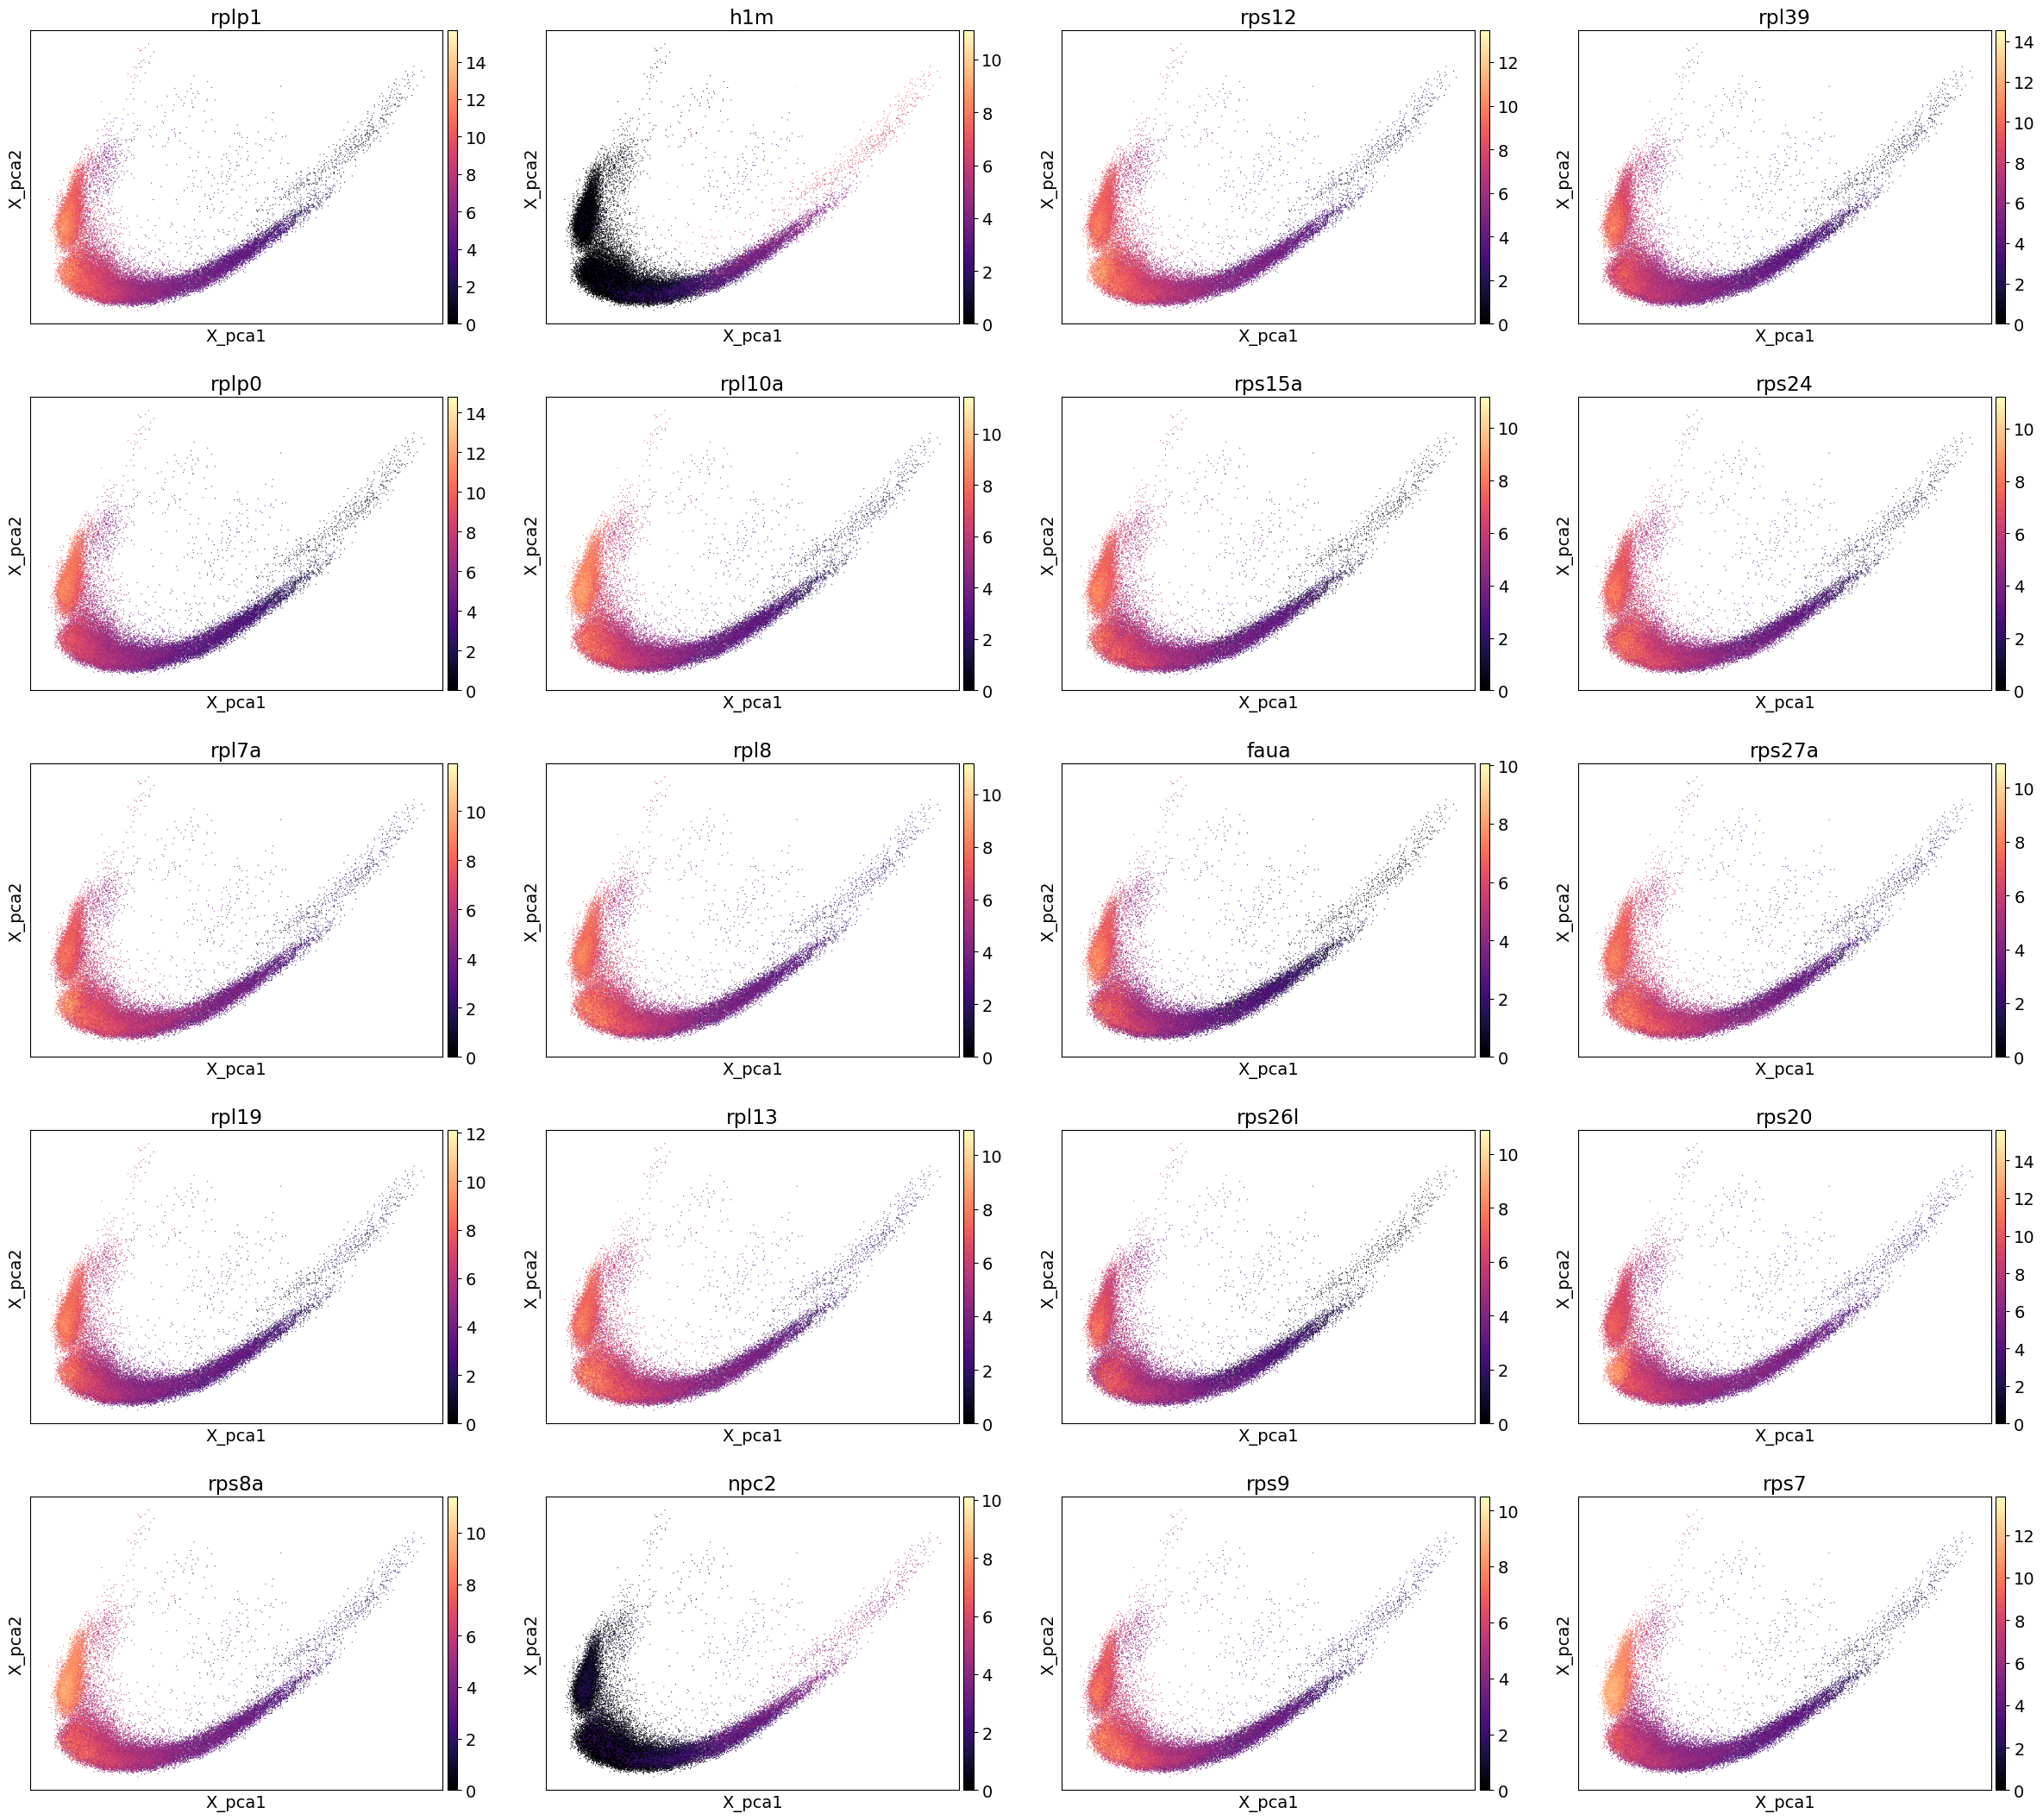

In [23]:
# Plot genes with the strongest effect on PC1
top_loadings = pc_loadings.transpose().PC1.abs().sort_values(ascending=False).head(20).index.to_list()
sc.pl.embedding(sdata, basis='X_pca', color=top_loadings, color_map='magma', 
                #save=f'.QC_{study}_PC1_top_genes.png'
               )


In [24]:
# # Create a graph using PCA embeddings with all genes
# G = gt.Graph(
#     sdata.obsm["X_pca"],  # PCA embeddings as input
#     n_pca=None,           # Use all PCA components
#     random_state=42,      # Ensure reproducibility
#     sample_idx=sdata.obs['BATCH'],  # Batch annotations for MNN kernel
#     verbose=True,         # Display progress messages
#     n_jobs=-2             # Use all available CPUs except one
# )

# # Define file path for saving the graph
# graph_file = f'{scratchdir}/preprocessed_data/Graph_expression_{study}_cells_all_genes_shier_coembedding.pkl'

# # Save the graph as a pickle file
# # G.to_pickle(graph_file)

# # Confirm successful save
# print(f"Graph saved to: {graph_file}")


### Transfer labels based on KNN classifier

In [25]:
# from pyFunctions.utils import knn_opt, knn_classify

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Classify unlabelled data using all data

def knn_classify(adata, # Anndata object with labled and unlabelled merged
                  label_col='Tissue', # Labels to classify data
                  filter=[True, True], # Bollean filter indicating unlabelled cells
                  knn=1, # Neighbourhood size for model
                  ):

    # Subset to labelled data
    X = adata.obsm['X_pca']
    X = X[~filter]
    
    # Get labels and remove NaNs
    y = adata[~filter].obs[label_col]
    if y.isnull().values.any():
        y = y.cat.add_categories('Unclassified')
        y = y.fillna('Unclassified')

    # Fit classifier to all data using optimised parameters
    knn = KNeighborsClassifier(n_neighbors=knn)
    knn.fit(X, y)
    
    # Subset to unlabelled data
    X_new = adata.obsm['X_pca']
    X_new = X_new[filter]
    
    # Predict labels for unlabelled data
    y_new = knn.predict(X_new)
    classification = pd.DataFrame(y_new, columns=[f'{label_col}_prediction'], index = adata.obs.index[filter])

    y_probs = knn.predict_proba(X_new)
    class_probs = pd.DataFrame(y_probs, columns=np.unique(y), index = adata.obs.index[filter])
    class_probs[f'{label_col}_prediction_probability'] = np.max(class_probs, axis=1)
    
    results = pd.concat([classification, class_probs], axis=1)
    
    return results


In [27]:
# Transfer labels from reference dataset
label = 'Tissue'

if sdata.obs.columns.isin([f'{label}_prediction', f'{label}_prediction_probability']).sum() > 0:
    sdata.obs.drop([f'{label}_prediction', f'{label}_prediction_probability'], axis=1, inplace=True)

# Transfer labels
classifications = knn_classify(adata=sdata, label_col=label, filter=sdata.obs[label] == "scMZNOS", knn=10)
# classifications.to_csv(f'{outdir}/{study}_{label}_knn_predicition_probability.csv')

# Add label predicition to obs
sdata.obs = sdata.obs.merge(classifications[[f'{label}_prediction', f'{label}_prediction_probability']], how='left', left_index=True, right_index=True)


In [35]:
# Count the number of WT cells types
sdata[((sdata.obs['Condition'] == 'Host') | (sdata.obs['Condition'] == 'WT'))].obs.Tissue_prediction.value_counts()

Tissue_prediction
Mid-Hindbrain boundary    1500
Eye                       1465
Ectoderm                  1110
Neural-early              1098
Epidermal-early            916
Neural-late                705
Epidermal                  459
Axial                      445
Forebrain                  352
Neural crest               262
Paraxial mesoderm          242
Tailbud                    165
Pharyngeal arch            138
Notochord                  118
Cardiac                    106
Somites                     98
Prechordal plate            95
Motoneurons                 84
Enveloping layer            74
Endoderm                    74
Ependymal                   60
Muscle                      53
Peripheral neurons          35
Epidermal-late              27
Haematopoietic              24
Cartilage                   14
PGCs                        12
Vascular                    10
Name: count, dtype: int64

In [41]:
# Add to scMZnps dataset
new_obs = sdata.obs[sdata.obs.BATCH == "scMZNOS"]
new_obs = new_obs[['Tissue_prediction']]
new_obs.index = new_obs.index.str.removesuffix('_0')
sdata_valtor.obs = sdata_valtor.obs.merge(new_obs, how='left', left_index=True, right_index=True)

Tissue_prediction
AAACGAAAGACTCCGC-1  Mid-Hindbrain boundary
AAACGAATCCCATAGA-1               Ependymal
AAACGAATCCTACGGG-1               Epidermal
AAACGCTTCCTAGAGT-1                   Axial
AAAGAACAGACAAGCC-1                   Axial
...                                    ...
TTTGTTGGTATCGGTT-3         Epidermal-early
TTTGTTGGTCGCAACC-3  Mid-Hindbrain boundary
TTTGTTGGTGACGCCT-3                Ectoderm
TTTGTTGTCGGCCCAA-3                Ectoderm
TTTGTTGTCTGGACTA-3               Forebrain

[10551 rows x 1 columns]

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatter

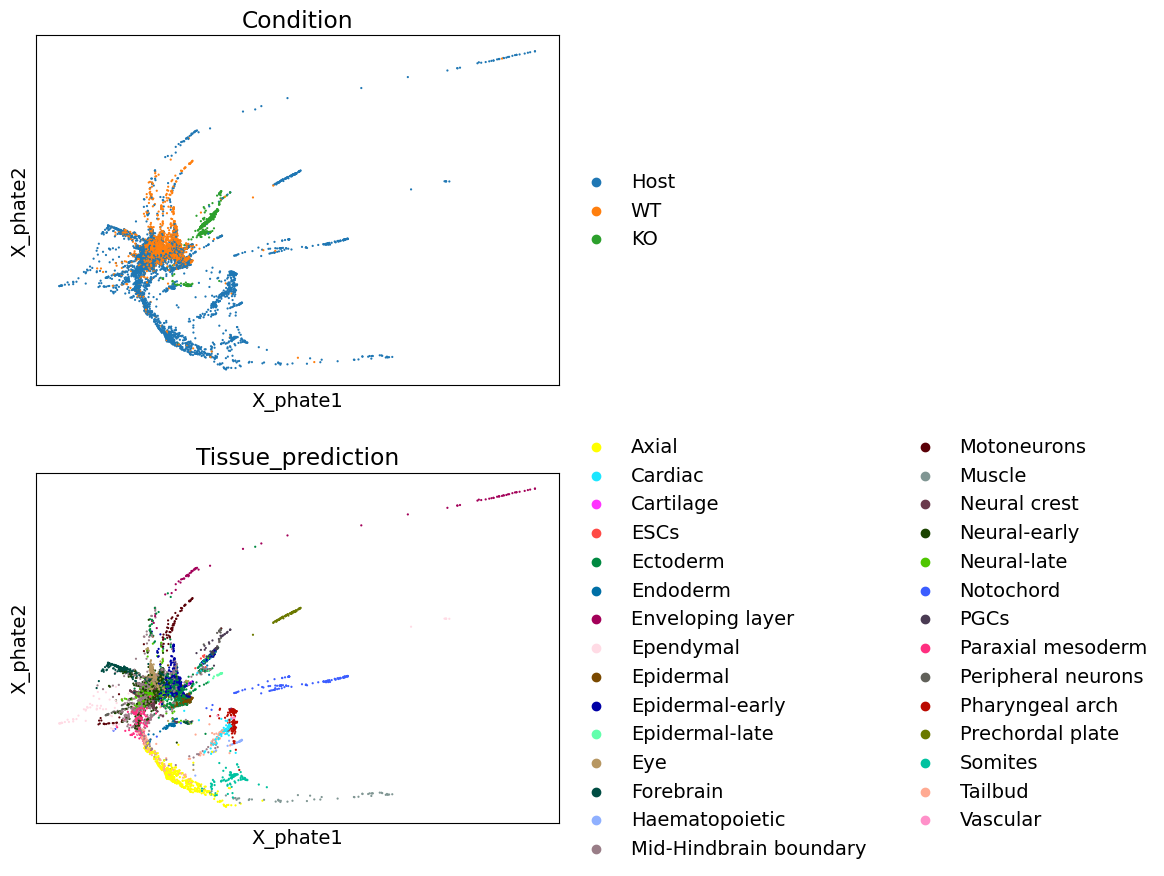

In [42]:
# Draw phate plot using all genes
sc.pl.embedding(sdata[~(sdata.obs['Condition'].isna())], basis='X_phate', sort_order=True, vmin=0, color=['Condition', 'Tissue_prediction'], size=10, use_raw = False, color_map='magma', ncols=1)


### Save results

In [ ]:
# # Save 12hpf obs with tissue and subtissue annotations
# sdata_valtor.obs.to_csv(f'{outdir}/preprocessed_data/Obs_{study}_cells_preprocessed_allhpf_annotated.csv')
# sdata.obs.to_csv(f'{outdir}/preprocessed_data/Obs_{study}_cells_preprocessed_coembedded_allhpf_annotated.csv')


In [ ]:
# # Save PCs and embeddings
# pd.DataFrame(sdata_valtor.obsm["X_phate_coembedding_allHPF"], index=sdata_valtor.obs.index, columns=['PHATE1', 'PHATE2']).to_csv(f'{outdir}/preprocessed_data/Obsm_PHATE_expression_{study}_cells_preprocessed_allhpf_annotated.csv')
# pd.DataFrame(sdata.obsm["X_phate"], index=sdata.obs.index, columns=['PHATE1', 'PHATE2']).to_csv(f'{outdir}/preprocessed_data/Obsm_PHATE_expression_{study}_cells_preprocessed_coembedded_allhpf_annotated.csv')


In [ ]:
# Save 12hpf with tissue and subtissue annotations
# sdata_valtor.write(f'{outdir}/preprocessed_data/Anndata_{study}_cells_preprocessed_allhpf_annotated.h5ad')
# sdata.write(f'{outdir}/preprocessed_data/Anndata_{study}_cells_preprocessed_coembedded_allhpf_annotated.h5ad')


In [ ]:
raise SystemExit("Relaxing...")